In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as p
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import scatterplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans




database_name = 'telecom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "admin",
                    "port": "5432", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")


## Loading the data and screening it

In [ ]:
# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)

In [ ]:
# To get a concise summary of the dataset i.e. data types, missing data,..
df.info()
pd.set_option('display.max_rows', None)

In [ ]:
# Display the first 10 rows of the dataframe
df.head(10)

In [ ]:
#List of column names
print(df.columns)

In [ ]:
# Find out the missing values
df.isna().sum()

In [ ]:
# Generate descriptive statistics
df.describe()

In [ ]:
#Returning a tuple with dimensions of the dataframe
print(df.shape)

## Task 2 sub tasks.

In [ ]:
# Identifying the top 10 of handsets used by the customers.
top_10_of_handsets =df['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:")
print(top_10_of_handsets)

In [ ]:
#Identify the top 3 handset manufacturers by count
top_3_manufacturers = df['Handset Manufacturer'].value_counts().head(3)

print("Top 3 Handset Manufacturers:")
print(top_3_manufacturers)

In [ ]:
#Find out the top 5 handsets in each of the top three manufactures
top_3_manufacturers = df['Handset Manufacturer'].value_counts().head(3).index.tolist()
filtered_df = df[df['Handset Manufacturer'].isin(top_3_manufacturers)]
top_5_handsets_per_manufacturer = filtered_df.groupby('Handset Manufacturer')['Handset Type'].value_counts().groupby('Handset Manufacturer').head(5)

print("Top 5 Handsets per Top 3 of the Handset Manufacturers:")
print(top_5_handsets_per_manufacturer)

In [ ]:
#Find out the bottom 5 handsets in each of the bottom three manufactures
bottom_3_manufacturers = df['Handset Manufacturer'].value_counts().tail(3).index.tolist()
filtered_df = df[df['Handset Manufacturer'].isin(bottom_3_manufacturers)]
bottom_5_handsets_per_manufacturer = filtered_df.groupby('Handset Manufacturer')['Handset Type'].value_counts().groupby('Handset Manufacturer').tail(5)

print("Botttom 5 Handsets per bottom 3 of the Handset Manufacturers:")
print(bottom_5_handsets_per_manufacturer)

In [ ]:
# Interpretation:
# The most used handset is Huawei B528S-23A.  It is also the only handset from the Huawei Manufacturer that appears in the top 10 most used handsets.
# I phone handsets seem to have the highest number of users as they take up 7 positions in top 10 mosted used handsets. 
# The top three handset manufacturers are Apple, Samsung, huawei respectively with each producing over 34400 handsets.
# In each the top 3 manufacturers, the leading handset also appears in the top 10 of the most used handsets. Also, all the top 5 handsets in the manufacturer, Apple, also 
# appear in the top 10 most used handsets overall.

# Recommendations:
# The marketing team should consider partnering with the handset manufactures, in a mutually benefitting way, in order to give promotions to customers using the top 10 handsets to enhance customer retention.
# They could also do the same for the least used handsets in order to broaden their customer base. 


# Task 2.1
## Overview of the users behaviour.

# number of xDR sessions per user

In [ ]:
# Select columns pertaining to applications and user data
user_app_columns = ['Bearer Id', 'Handset Manufacturer', 'Handset Type', 'Social Media DL (Bytes)',
                    'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
                    'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                    'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                    'Other DL (Bytes)', 'Other UL (Bytes)']

In [ ]:
df_user_apps = df[user_app_columns]

In [ ]:
# To count the number of xDR sessions per user

df_user_apps['Number of xDR Sessions'] = df_user_apps.groupby('Bearer Id')['Bearer Id'].transform('count')

In [ ]:
# Extracting the relevant columns for the result
result_columns = ['Bearer Id', 'Number of xDR Sessions']

result = df_user_apps[result_columns].drop_duplicates().reset_index(drop=True)
print(result)

In [ ]:
# Aggregate session duration per user
session_dur_per_user = df.groupby('Bearer Id')['Dur. (ms)'].sum().reset_index(name='Session Duration (ms)')

print(session_dur_per_user)

In [ ]:
# Aggregate the total download and upload data per user
total_data_per_user =pd.DataFrame (df.groupby('Bearer Id')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index())

print(total_data_per_user)

In [ ]:
# Define the columns related to applications
application_columns = ['Bearer Id', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                        'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                        'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                         'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                         'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)'
                        
                       ]

# Aggregate the total data volume per user and application
total_data_per_user_app = df[application_columns].groupby('Bearer Id').sum().reset_index()

print(total_data_per_user_app)

# Task 2.2

In [ ]:
# Creating separate dataframes for columns with numbers and objects.
num_col = df.select_dtypes (include = ['number']).columns
cat_col = df.select_dtypes (include = ['object']).columns

df_num = df[num_col]
df_cat = df[cat_col]

print("Numerical Columns:", num_col)
print("Categorical Columns:", cat_col)

In [ ]:
# filling in missing values with mean
df_num = df_num.fillna(df_num.mean())

In [ ]:
# Checking for missing values
df_num.isna().sum()

In [ ]:
# Replacing outliers with mean

def replace_outliers_with_mean(df_num, threshold=3):
    for col in df_num.columns:
        z_scores = (df_num[col] - df_num[col].mean()) / df_num[col].std()
        outlier_mask = (z_scores > threshold) | (z_scores < -threshold)
        df_num[col][outlier_mask] = df_num[col].mean()
    return df_num

df_num = replace_outliers_with_mean(df_num)

In [ ]:
# Basic metrics
df_num.describe()

In [ ]:
correlation_matrix = df_num.corr()
print(correlation_matrix)

In [ ]:


columns_to_plot = ['Dur. (ms)', 'Avg RTT DL (ms)',
                   'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',  
                   'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                    'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                    'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                    'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                    'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']

# Set up subplots
num_plots = len(columns_to_plot)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 4 * num_plots))

# Plot histograms for the columns
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df_num[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:

columns_to_plot = ['Dur. (ms)', 'Avg RTT DL (ms)',
                   'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
                   'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                   'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                   'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                   'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                   'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']

# Set up subplots
num_plots = len(columns_to_plot)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 4 * num_plots))

# Plot box plots for the columns
for i, column in enumerate(columns_to_plot):
    axes[i].boxplot(df_num[column])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
df_num['Total Bytes Sum'] = df_num['Total DL (Bytes)'] + df_num['Total UL (Bytes)']
print(df_num['Total Bytes Sum'])

In [ ]:
#Define the social media columns and find their correlations to the Total Bytes

application_columns2 = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                        'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                        'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                         'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                         'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)'
                        
                       ]


correlations = df_num[application_columns2 + ['Total Bytes Sum']]. corr()
correlations

In [ ]:

for app_column in application_columns2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Total Bytes Sum', y=app_column, data=df_num)  
    plt.title(f'Scatter Plot: {app_column} vs Total Bytes Sum')
    plt.xlabel('Total Bytes Sum')
    plt.ylabel(app_column)
    plt.show()


In [ ]:
correlation_matrix = df_num[application_columns2 + ['Total Bytes Sum']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()      
            

In [ ]:
df_num['Total Duration'] = df_num['Dur. (ms)']

# Creating decile classes based on total duration.
df_num['Duration Decile'] = pd.qcut(df_num['Total Duration'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False, precision=0)

# Group by 'MSISDN/Number' and 'Duration Decile', then compute the sum of 'Total Bytes Sum' for each group
decile_totals = df_num.groupby(['MSISDN/Number', 'Duration Decile'])['Total Bytes Sum'].sum().reset_index()

# Get the top five decile classes
top_five_deciles = decile_totals.groupby('Duration Decile')['Total Bytes Sum'].sum().nlargest(5).index

# Filter the DataFrame for the top five decile classes
top_five_deciles_data = decile_totals[decile_totals['Duration Decile'].isin(top_five_deciles)]

# Display the result
print(top_five_deciles_data)

In [ ]:
# Subset the DataFrame with the application columns.
subset_df = df_num[application_columns2]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr

print(correlation_matrix)

## Task 3 User Engagement Analysis

In [ ]:
#Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
engagement_metrics = ['sessions frequency', 'session duration', 'sessions total traffic']

df_num['Start'] = pd.to_datetime(df_num['Start ms'], unit='ms')
df_num['End'] = pd.to_datetime(df_num['End ms'], unit='ms')

df_num['session duration'] = (df_num['End'] - df_num['Start']).dt.total_seconds()

df_engagement = df_num.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',                         # sessions frequency
    'session duration': 'sum',                   # session duration
    'Total Bytes Sum': 'sum'  # sessions total traffic
}).reset_index()

df_engagement.columns = ['MSISDN', 'sessions frequency', 'session duration', 'sessions total traffic']

for metric in engagement_metrics:
    top_10_customers = df_engagement.nlargest(10, metric)
    print(f"Top 10 customers by {metric}:\n{top_10_customers[['MSISDN', metric]]}\n")


In [ ]:
# Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
engagement_metrics_for_clustering = ['sessions frequency', 'session duration', 'sessions total traffic']

engagement_data = df_engagement[engagement_metrics_for_clustering]

scaler = StandardScaler()
normalized_engagement_data = scaler.fit_transform(engagement_data)

kmeans = KMeans(n_clusters=3, random_state=42)
df_engagement['Cluster'] = kmeans.fit_predict(normalized_engagement_data)

print("K-Means Clustering Results:")
print(df_engagement[['MSISDN', 'Cluster']])

In [ ]:
# Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.
original_metrics = ['sessions frequency', 'session duration', 'sessions total traffic']

cluster_summary = df_engagement.groupby('MSISDN')[original_metrics].agg(['min', 'max', 'mean', 'sum']).reset_index()

print("Cluster Summary:")
print(cluster_summary)


In [ ]:

original_metrics = ['sessions frequency', 'session duration', 'sessions total traffic']

cluster_summary = df_engagement.groupby('Cluster')[original_metrics].agg(['min', 'max', 'mean', 'sum']).reset_index()

print("Cluster Summary:")
print(cluster_summary)


plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sessions frequency', data=df_engagement)
plt.title('Sessions Frequency by Cluster')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='session duration', data=df_engagement)
plt.title('Sessions duration by Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='sessions total traffic', data=df_engagement)
plt.title('Sessions total traffic by Cluster')
plt.show()


In [ ]:
# Aggregate user total traffic per application and derive the top 10 most engaged users per application.
import pandas as pd

# Assuming 'IMEI' is the correct column name
user_identifier = 'IMEI'

# Assuming you have columns like 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', etc.
application_columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                        'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                        'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                        'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                        'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']

# Selecting relevant columns
columns_of_interest = [user_identifier] + application_columns

# Creating a new DataFrame with relevant columns
df_app_traffic = df_num[columns_of_interest]

# Handling possible missing values in the columns
df_app_traffic[application_columns] = df_app_traffic[application_columns].fillna(0)

# Aggregating total traffic per application for each user
df_app_traffic['Total Traffic'] = df_app_traffic[application_columns].sum(axis=1)

# Sorting the DataFrame by 'Total Traffic' in descending order
df_app_traffic = df_app_traffic.sort_values(by='Total Traffic', ascending=False)

# Grouping by each application and finding the top 10 most engaged users
top_users_per_app = df_app_traffic.groupby(user_identifier).head(10).reset_index(drop=True)

# Displaying the top users per application
print(top_users_per_app)





# Task 4 Experience Analysis.


In [ ]:
# Filing in missing values in my categorical dataframe.
for column in df_cat.columns:
    df_cat[column] = df_cat[column].fillna(df_cat[column].mode()[0])

In [ ]:
df_cat.isna().sum()

In [ ]:
# Create a new column for the total TCP retransmission volume
df_num['Total TCP Retrans. Vol (Bytes)'] = df_num['TCP DL Retrans. Vol (Bytes)'] + df_num['TCP UL Retrans. Vol (Bytes)']

# Group by ' 'MSISDN/Number'' and calculate the average TCP retransmission for each customer
agg_df = df_num.groupby( 'MSISDN/Number')['Total TCP Retrans. Vol (Bytes)'].mean().reset_index()

print(agg_df)

In [ ]:
# Create a new column for the total RTT (sum of DL and UL)
df_num['Total RTT (ms)'] = df_num['Avg RTT DL (ms)'] + df_num['Avg RTT UL (ms)']

# Group by 'MSISDN' and calculate the average RTT for each customer
agg_rtt_df = df_num.groupby('MSISDN/Number')['Total RTT (ms)'].mean().reset_index()

print(agg_rtt_df)

In [ ]:
# Aggregate, per customer, Handset type

agg_handset_df = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

print(agg_handset_df)

In [ ]:
# Create a new column for the total throughput (sum of DL and UL)
df['Total Throughput (kbps)'] = df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']

# Group by 'MSISDN' and calculate the average throughput for each customer
agg_throughput_df = df.groupby('MSISDN/Number')['Total Throughput (kbps)'].mean().reset_index()

print(agg_throughput_df)

In [ ]:

# Extract TCP values from the DataFrame
tcp_values = df_num[['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']].stack().reset_index(drop=True)

top_tcp_values = tcp_values.nlargest(10)
print("Top 10 TCP values:")
print(top_tcp_values)

bottom_tcp_values = tcp_values.nsmallest(10)
print("\nBottom 10 TCP values:")
print(bottom_tcp_values)

most_frequent_tcp_values = tcp_values.value_counts().head(10)
print("\nMost frequent TCP values:")
print(most_frequent_tcp_values)


In [ ]:

# Extract RTT values from the DataFrame
rtt_values = df[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].stack().reset_index(drop=True)

top_rtt_values = rtt_values.nlargest(10)
print("Top 10 RTT values:")
print(top_rtt_values)

bottom_rtt_values = rtt_values.nsmallest(10)
print("\nBottom 10 RTT values:")
print(bottom_rtt_values)

most_frequent_rtt_values = rtt_values.value_counts().head(10)
print("\nMost frequent RTT values:")
print(most_frequent_rtt_values)


In [ ]:

# Extract Throughput values from the DataFrame
throughput_values = df_num[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].stack().reset_index(drop=True)

# Display the top 10 Throughput values
top_throughput_values = throughput_values.nlargest(10)
print("Top 10 Throughput values:")
print(top_throughput_values)

# Display the bottom 10 Throughput values
bottom_throughput_values = throughput_values.nsmallest(10)
print("\nBottom 10 Throughput values:")
print(bottom_throughput_values)

# Display the most frequent Throughput values
most_frequent_throughput_values = throughput_values.value_counts().head(10)
print("\nMost frequent Throughput values:")
print(most_frequent_throughput_values)


In [ ]:
# Create a new column for the total throughput (sum of DL and UL)
df['Total Throughput (kbps)'] = df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']

# Group by 'Handset Type' and calculate the average throughput for each handset type
throughput_by_handset = df.groupby('Handset Type')['Total Throughput (kbps)'].mean().reset_index()

# Plot a histogram to visualize the distribution of average throughput
plt.figure(figsize=(10, 6))
plt.hist(throughput_by_handset['Total Throughput (kbps)'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Average Throughput by Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the summary statistics of average throughput by handset type
print("Summary Statistics of Average Throughput by Handset Type:")
print(throughput_by_handset.describe())

# Display the distribution of average throughput by handset type
print("Distribution of Average Throughput by Handset Type:")
print(throughput_by_handset)



In [ ]:
df
# Create a new column for the total TCP retransmission volume
df['Total TCP Retrans. Vol (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'] + df_num['TCP UL Retrans. Vol (Bytes)']

# Group by 'Handset Type' and calculate the average TCP retransmission for each handset type
tcp_retransmission_by_handset = df.groupby('Handset Type')['Total TCP Retrans. Vol (Bytes)'].mean().reset_index()

# Display the top 10 and bottom 10 handsets based on average TCP retransmission
top_10_handsets = tcp_retransmission_by_handset.nlargest(10, 'Total TCP Retrans. Vol (Bytes)')
bottom_10_handsets = tcp_retransmission_by_handset.nsmallest(10, 'Total TCP Retrans. Vol (Bytes)')

print("Top 10 Handsets:")
print(top_10_handsets)

print("\nBottom 10 Handsets:")
print(bottom_10_handsets)



c:\Users\Dorcas\Anaconda installation files\envs\programmingexpert\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of users in each cluster:
Cluster
1    114842
0     32702
2      2457
Name: count, dtype: int64


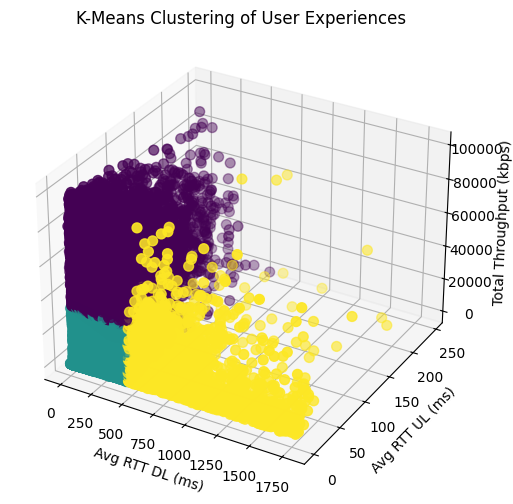

In [255]:


# Select relevant features for clustering
selected_features = df_num[['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Total Throughput (kbps)']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_num['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the count of users in each cluster
print("Number of users in each cluster:")
print(df_num['Cluster'].value_counts())

# Plot clusters in 3D space for the first three features
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_num['Avg RTT DL (ms)'], df_num['Avg RTT UL (ms)'], df_num['Total Throughput (kbps)'], c=df_num['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Avg RTT DL (ms)')
ax.set_ylabel('Avg RTT UL (ms)')
ax.set_zlabel('Total Throughput (kbps)')
plt.title('K-Means Clustering of User Experiences')
plt.show()


## Task 5 Satisfaction Analysis